In [1]:
import gymnasium
import matplotlib.pyplot as plt
import numpy as np
from ml_collections import config_dict
from numpy.typing import NDArray
from scipy.spatial.transform import Rotation as R

from crazyflow.constants import MASS, J
from crazyflow.control import Control
from crazyflow.sim.physics import Physics
from crazyflow.sim.symbolic import symbolic


In [2]:
sim_config = config_dict.ConfigDict()
sim_config.device = "cpu"
sim_config.physics = Physics.default
sim_config.control = Control.thrust
sim_config.thrust_freq = 500
sim_config.n_drones = 1
sim_config.n_worlds = 1 #20

envs = gymnasium.make_vec(
    "DroneReachPos-v0",
    # return_datatype="numpy",
    num_envs=sim_config.n_worlds,
    **sim_config,
)

In [3]:
def obs_to_state(obs: dict[str, NDArray]) -> NDArray:
    """Convert the observation from the obs dictionary to the state vector."""
    # Extract position
    pos = obs["pos"].squeeze()  # shape: (3,)
    
    # Extract linear velocity
    vel = obs["vel"].squeeze()  # shape: (3,)
    
    # Extract orientation as quaternion and convert to Euler angles
    quat = obs["quat"].squeeze()  # shape: (4,)
    euler = R.from_quat(quat).as_euler("xyz")  # shape: (3,), Euler angles
    # euler = euler[::-1] # [roll, pitch, yaw]
    # Extract angular velocity
    rpy_rates = obs["rpy_rates"].squeeze()  # shape: (3,)
    
    # Concatenate into a single state vector
    state = np.array([pos[0],vel[0],pos[1],vel[1],pos[2],vel[2],*euler, *rpy_rates])
    
    return state

Set up symbolic model.

In [4]:
dt = 1/envs.sim.freq
symbolic_model = symbolic(MASS, J, dt)

In [5]:
x_sim_log = []
y_sim_log = []
z_sim_log = []
x_sym_log = []
y_sym_log = []
z_sym_log = []

x_dot_sim_log = []
y_dot_sim_log = []
z_dot_sim_log = []
x_dot_sym_log = []
y_dot_sym_log = []
z_dot_sym_log = []

roll_sim_log = []
pitch_sim_log = []
yaw_sim_log = []
roll_sym_log = []
pitch_sym_log = []
yaw_sym_log = []

roll_dot_sim_log = []
pitch_dot_sim_log = []
yaw_dot_sim_log = []
roll_dot_sym_log = []
pitch_dot_sym_log = []
yaw_dot_sym_log = []

In [6]:
obs, info = envs.reset()
state = obs_to_state(obs)
print(state)
x_sim_log.append(state[0])
y_sim_log.append(state[2])
z_sim_log.append(state[4])
roll_sim_log.append(state[6])
pitch_sim_log.append(state[7])
yaw_sim_log.append(state[8])

x_sym_log.append(state[0])
y_sym_log.append(state[2])
z_sym_log.append(state[4])
roll_sym_log.append(state[6])
pitch_sym_log.append(state[7])
yaw_sym_log.append(state[8])

x_dot_sim_log.append(state[1])
y_dot_sim_log.append(state[3])
z_dot_sim_log.append(state[5])
x_dot_sym_log.append(state[1])
y_dot_sym_log.append(state[3])
z_dot_sym_log.append(state[5])

roll_dot_sim_log.append(state[9])
pitch_dot_sim_log.append(state[10])
yaw_dot_sim_log.append(state[11])
roll_dot_sym_log.append(state[9])
pitch_dot_sym_log.append(state[10])
yaw_dot_sym_log.append(state[11])

[-0.68290544 -0.10079145 -0.68805647 -0.99958229  1.98836303 -0.48329139
  0.          0.          0.          0.          0.          0.        ]


Randomly generate actions.

In [7]:
low = 0.028161688
high = 0.14834145
shape = (1, 4)
xf = state

for i in range(200):
    random_input = np.random.uniform(low=low, high=high, size=shape).astype(np.float32)

    print("input:", random_input)

    res = symbolic_model.fd_func(x0=xf, p=random_input)
    xf = res["xf"].full().flatten()
    print("xf from symbolic:", xf)
    x_sym_log.append(xf[0])
    y_sym_log.append(xf[2])
    z_sym_log.append(xf[4])
    x_dot_sym_log.append(xf[1])
    y_dot_sym_log.append(xf[3])
    z_dot_sym_log.append(xf[5])
    roll_sym_log.append(xf[6])
    pitch_sym_log.append(xf[7])
    yaw_sym_log.append(xf[8])
    roll_dot_sym_log.append(xf[9])
    pitch_dot_sym_log.append(xf[10])
    yaw_dot_sym_log.append(xf[11])

    obs, reward, terminated, truncated, info = envs.step(random_input)
    state = obs_to_state(obs)

    print("state from sim:", state)
    x_sim_log.append(state[0])
    y_sim_log.append(state[2])
    z_sim_log.append(state[4])
    x_dot_sim_log.append(state[1])
    y_dot_sim_log.append(state[3])
    z_dot_sim_log.append(state[5])
    roll_sim_log.append(state[6])
    pitch_sim_log.append(state[7])
    yaw_sim_log.append(state[8])
    roll_dot_sim_log.append(state[9])
    pitch_dot_sim_log.append(state[10])
    yaw_dot_sim_log.append(state[11])
    envs.render()
envs.sim.close()
envs.close()

input: [[0.0342352  0.06268372 0.07300714 0.03125096]]
xf from symbolic: [-6.83107018e-01 -1.00790466e-01 -6.90055634e-01 -9.99582394e-01
  1.98739173e+00 -4.88009386e-01  1.99165893e-05  1.90532330e-04
 -2.06728497e-05  1.99185904e-02  1.90526627e-01 -2.06743264e-02]
state from sim: [-0.68310702 -0.10079145 -0.69005561 -0.99958229  1.98739648 -0.48800939
  0.          0.          0.          0.01991766  0.19052672 -0.02067434]
input: [[0.06471737 0.12105002 0.05893433 0.05319828]]
xf from symbolic: [-6.83308591e-01 -1.00780780e-01 -6.92054798e-01 -9.99581759e-01
  1.98641815e+00 -4.85562723e-01 -1.40087133e-04  7.40058383e-04
  1.65737223e-05 -1.79921365e-01  3.58971173e-01  5.79307791e-02]
state from sim: [-6.83308601e-01 -1.00791454e-01 -6.92054749e-01 -9.99582291e-01
  1.98642051e+00 -4.85562712e-01  3.98353241e-05  3.81053459e-04
 -4.13486842e-05 -1.79878145e-01  3.58978271e-01  5.80136478e-02]
input: [[0.03035168 0.09753152 0.11276823 0.08161705]]
xf from symbolic: [-6.83510128e-

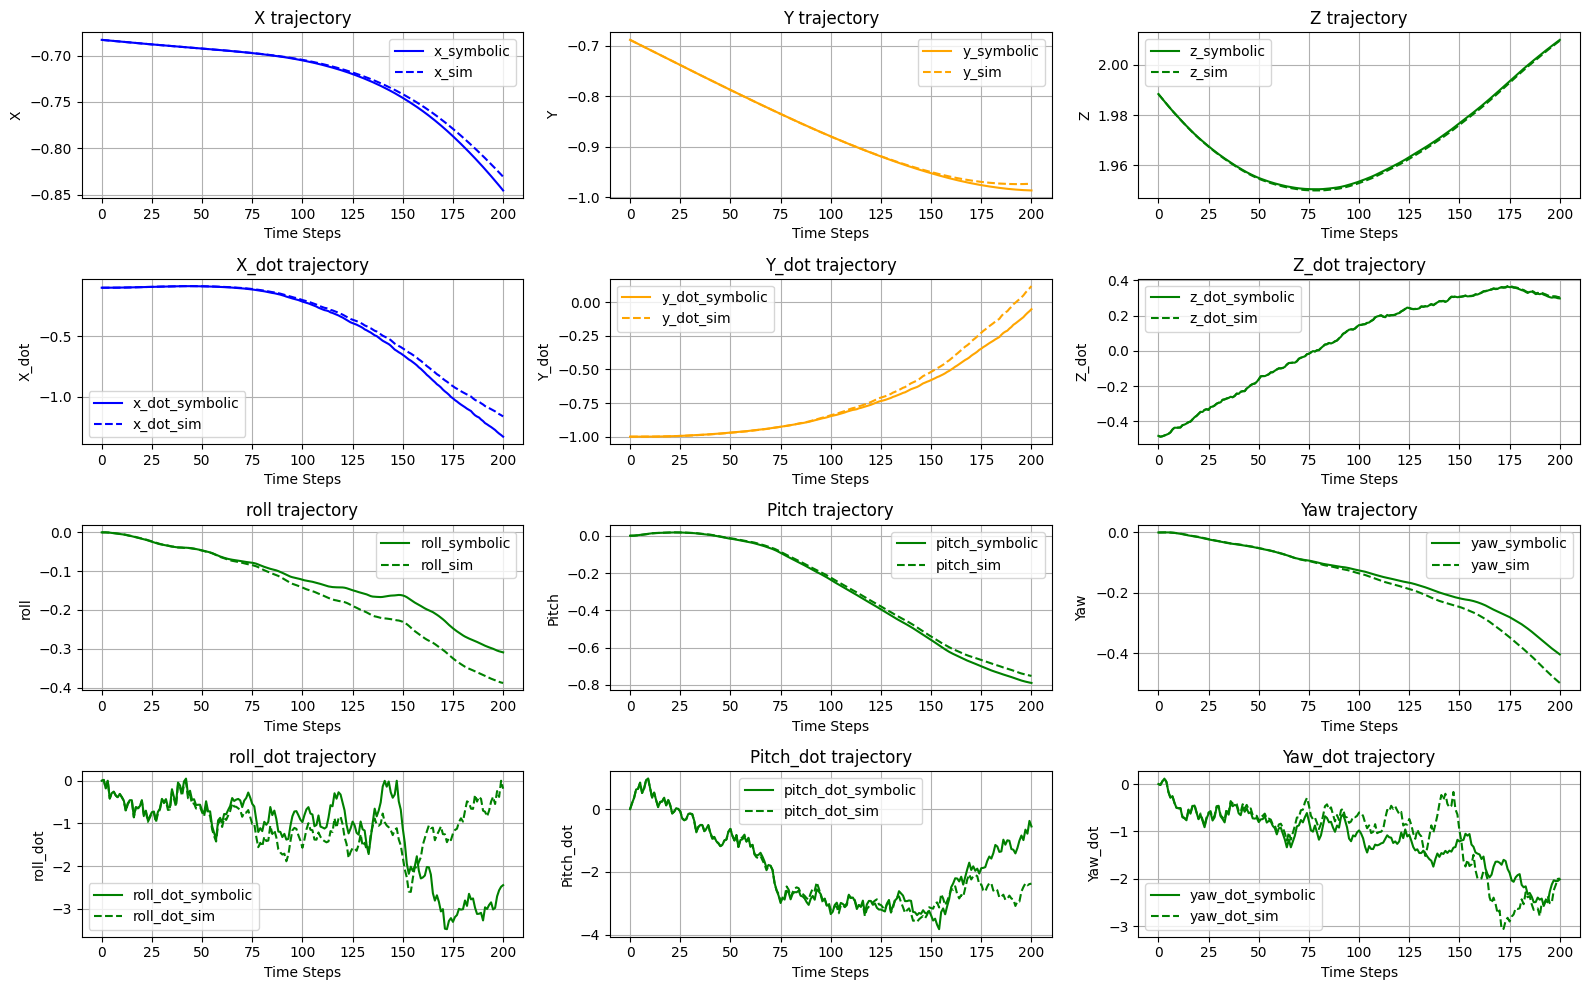

In [8]:
time = np.arange(len(x_sym_log))  

plt.figure(figsize=(16, 10))

# X
plt.subplot(4, 3, 1)
plt.plot(time, x_sym_log, label='x_symbolic', color='blue')
plt.plot(time, x_sim_log, label='x_sim', color='blue', linestyle='--')
plt.title('X trajectory')
plt.xlabel('Time Steps')
plt.ylabel('X')
plt.legend()
plt.grid(True)

# Y
plt.subplot(4, 3, 2)
plt.plot(time, y_sym_log, label='y_symbolic', color='orange')
plt.plot(time, y_sim_log, label='y_sim', color='orange', linestyle='--')
plt.title('Y trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Y')
plt.legend()
plt.grid(True)

# Z
plt.subplot(4, 3, 3)
plt.plot(time, z_sym_log, label='z_symbolic', color='green')
plt.plot(time, z_sim_log, label='z_sim', color='green', linestyle='--')
plt.title('Z trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Z')
plt.legend()
plt.grid(True)

# X_dot
plt.subplot(4, 3, 4)
plt.plot(time, x_dot_sym_log, label='x_dot_symbolic', color='blue')
plt.plot(time, x_dot_sim_log, label='x_dot_sim', color='blue', linestyle='--')
plt.title('X_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('X_dot')
plt.legend()
plt.grid(True)

# Y_dot
plt.subplot(4, 3, 5)
plt.plot(time, y_dot_sym_log, label='y_dot_symbolic', color='orange')
plt.plot(time, y_dot_sim_log, label='y_dot_sim', color='orange', linestyle='--')
plt.title('Y_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Y_dot')
plt.legend()
plt.grid(True)

# Z_dot
plt.subplot(4, 3, 6)
plt.plot(time, z_dot_sym_log, label='z_dot_symbolic', color='green')
plt.plot(time, z_dot_sim_log, label='z_dot_sim', color='green', linestyle='--')
plt.title('Z_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Z_dot')
plt.legend()
plt.grid(True)

# Roll
plt.subplot(4, 3, 7)
plt.plot(time, roll_sym_log, label='roll_symbolic', color='green')
plt.plot(time, roll_sim_log, label='roll_sim', color='green', linestyle='--')
plt.title('roll trajectory')
plt.xlabel('Time Steps')
plt.ylabel('roll')
plt.legend()
plt.grid(True)

# Pitch
plt.subplot(4, 3, 8)
plt.plot(time, pitch_sym_log, label='pitch_symbolic', color='green')
plt.plot(time, pitch_sim_log, label='pitch_sim', color='green', linestyle='--')
plt.title('Pitch trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Pitch')
plt.legend()
plt.grid(True)

# Yaw
plt.subplot(4, 3, 9)
plt.plot(time, yaw_sym_log, label='yaw_symbolic', color='green')
plt.plot(time, yaw_sim_log, label='yaw_sim', color='green', linestyle='--')
plt.title('Yaw trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Yaw')
plt.legend()
plt.grid(True)

# Roll_dot
plt.subplot(4, 3, 10)
plt.plot(time, roll_dot_sym_log, label='roll_dot_symbolic', color='green')
plt.plot(time, roll_dot_sim_log, label='roll_dot_sim', color='green', linestyle='--')
plt.title('roll_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('roll_dot')
plt.legend()
plt.grid(True)

# Pitch_dot
plt.subplot(4, 3, 11)
plt.plot(time, pitch_dot_sym_log, label='pitch_dot_symbolic', color='green')
plt.plot(time, pitch_dot_sim_log, label='pitch_dot_sim', color='green', linestyle='--')
plt.title('Pitch_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Pitch_dot')
plt.legend()
plt.grid(True)

# Yaw_dot
plt.subplot(4, 3, 12)
plt.plot(time, yaw_dot_sym_log, label='yaw_dot_symbolic', color='green')
plt.plot(time, yaw_dot_sim_log, label='yaw_dot_sim', color='green', linestyle='--')
plt.title('Yaw_dot trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Yaw_dot')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()